## Vector Autoregression (VAR)

In [5]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Markov-Switching ARIMA

In [2]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Load data
data = pd.read_csv('../assets/datas/BrentOilPrices.csv')

# Convert Date to datetime and set it as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Fit ARIMA model (you may need to tune p, d, q)
model = ARIMA(data['Price'], order=(5,1,0))  # Example: AR(5), I(1), MA(0)
results = model.fit()

# Print summary
print(results.summary())


/tmp/ipykernel_97898/3376751919.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])
/home/teddy/Desktop/Kifya journey/Kifiya-AIM-Week-10/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/teddy/Desktop/Kifya journey/Kifiya-AIM-Week-10/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/teddy/Desktop/Kifya journey/Kifiya-AIM-Week-10/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarn

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9011
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -14540.613
Date:                Tue, 25 Feb 2025   AIC                          29093.226
Time:                        14:18:00   BIC                          29135.862
Sample:                             0   HQIC                         29107.733
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0260      0.006      4.344      0.000       0.014       0.038
ar.L2         -0.0235      0.006     -4.231      0.000      -0.034      -0.013
ar.L3         -0.0071      0.005     -1.507      0.1

## LSTM (Long Short-Term Memory) Networks



In [10]:

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

# Prepare data for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X, Y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, batch_size=1, epochs=1)


/home/teddy/Desktop/Kifya journey/Kifiya-AIM-Week-10/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7160/7160 ━━━━━━━━━━━━━━━━━━━━ 195s 27ms/step - loss: 0.0015


## Make Predictions and compare

224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


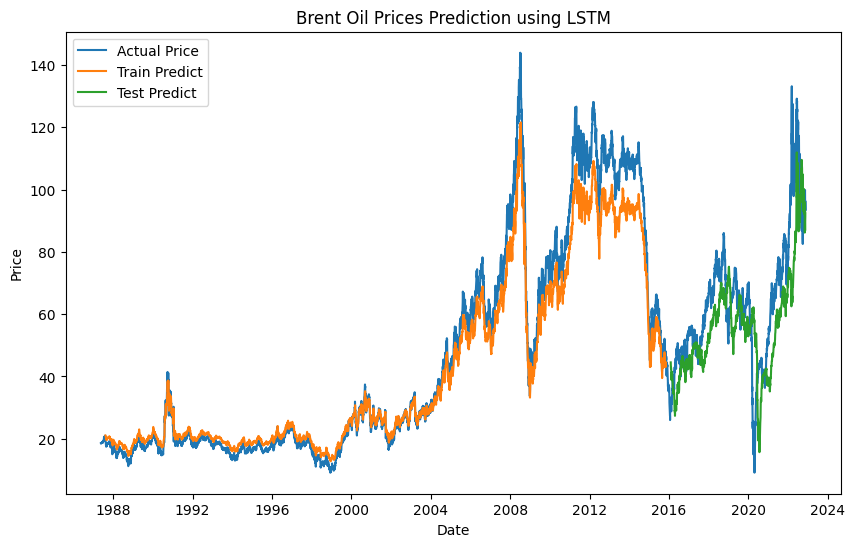

In [13]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))


# Plot the results
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = \
    test_predict[:len(scaled_data) - len(train_predict) - (time_step * 2) - 2]  

plt.figure(figsize=(10, 6))
plt.plot(data.index, scaler.inverse_transform(scaled_data), label='Actual Price')
plt.plot(data.index, train_predict_plot, label='Train Predict')
plt.plot(data.index, test_predict_plot, label='Test Predict')
plt.title('Brent Oil Prices Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()